In [132]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math


def filtering_2d(image, kernel, sobel=False):
    img_h, img_w = image.shape
    kernel_h, kernel_w = kernel.shape

    res_h = img_h - kernel_h + 1
    res_w = img_w - kernel_w + 1
    res = np.zeros((res_h, res_w))

    for h in range(res_h):
        for w in range(res_w):
            total_sum = np.sum(image[h : h + kernel_h, w : w + kernel_w] * kernel)
            res[h, w] = total_sum if sobel == False else abs(total_sum)

    return res


def get_grad_mag(matrix_1, matrix_2):
    height, width = matrix_1.shape
    output = np.zeros((height, width))

    for h in range(height):
        for w in range(width):
            pixel_1 = matrix_1[h, w]
            pixel_2 = matrix_2[h, w]
            output[h, w] = math.sqrt(pixel_1**2 + pixel_2**2)

    return output


def get_grad_angle(matrix_1, matrix_2):
    height, width = matrix_1.shape
    output = np.zeros((height, width))

    for h in range(height):
        for w in range(width):
            pixel_1 = matrix_1[h, w]
            pixel_2 = matrix_2[h, w]
            output[h, w] = math.degrees(math.atan2(pixel_2, pixel_1))

    return output


def angle_classification(gradient_angles):
    height, width = gradient_angles.shape
    gradient_angles = gradient_angles % 180
    result = np.zeros((height, width))

    for h in range(height):
        for w in range(width):
            angle = gradient_angles[h, w]

            match angle:
                case _ if 22.5 <= angle < 67.5:
                    result[h, w] = 45
                case _ if 67.5 <= angle < 112.5:
                    result[h, w] = 90
                case _ if 112.5 <= angle < 157.5:
                    result[h, w] = 135
                case _ if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                    result[h, w] = 0

    return result


def non_max_suppression(magnitude, angles):
    height, width = magnitude.shape
    result = np.copy(magnitude)

    for h in range(1, height - 1):
        for w in range(1, width - 1):
            angle = angles[h, w]
            mag = magnitude[h, w]
            match angle:
                case 0:
                    # compare left and right neighboring pixels
                    if mag < magnitude[h, w - 1] or mag < magnitude[h, w + 1]:
                        result[h, w] = 0
                case 45:
                    # compare lower left diagnol and upper right neighboring pixels
                    if mag < magnitude[h - 1, w + 1] or mag < magnitude[h + 1, w - 1]:
                        result[h, w] = 0
                case 90:
                    # compare top and bottom pixels
                    if mag < magnitude[h - 1, w] or mag < magnitude[h + 1, w]:
                        result[h, w] = 0
                case 135:
                    # compare upper left and lower right pixels
                    if mag < magnitude[h - 1, w - 1] or mag < magnitude[h + 1, w + 1]:
                        result[h, w] = 0
    return result


def hysteresis_thresholding(nms_img, min_t, max_t):
    # create masks based on min and max threshold 
    strong_px_mask = (nms_img >= min_t).astype(np.uint8)
    weak_px_mask = ((nms_img >= min_t) & (nms_img < max_t)).astype(np.uint8)
    height, width = nms_img.shape

    result = np.zeros_like(nms_img, dtype=np.uint8)
    result[strong_px_mask == 1] = 255 # mark the existing strong edges as 255.

    # For every weak edge int the pixel matrix, check if it is connected
    # with 8 surrounding strong edges. If true, mark the edge as strongly 
    # connected with 255 (white color).
    # 8 because we want to compare horizantal, vertical and diagnoal
    # neigboring pixels. With 4, diagnol pixels will get ignored.
    for h in range(1, height - 1):
        for w in range(1, width - 1):
            if weak_px_mask[h, w] == 1:
                if (
                    strong_px_mask[h - 1, w - 1] == 1 # upper left diagnoal pixel
                    or strong_px_mask[h - 1, w + 1] == 1 # lower left diagnoal pixel
                    or strong_px_mask[h + 1, w - 1] == 1 # upper right diagnoal pixel
                    or strong_px_mask[h + 1, w + 1] == 1 # lower right diagnol pixel
                    or strong_px_mask[h - 1, w] == 1 # left pixel
                    or strong_px_mask[h + 1, w] == 1 # right pixel
                    or strong_px_mask[h, w - 1] == 1 # top pixel
                    or strong_px_mask[h, w + 1] == 1 # bottom pixel
                ):
                    result[h, w] = 255

    return result

In [133]:
img_name = "image-3"
result_dir = f"results/{img_name}"
img = Image.open(f"dataset/{img_name}.jpeg")

# conversion to gray image is imporant.
# Otherwise, computational will be required
# across 3 channels (R,G,B) at each step, which is
# is unnecessary for highliting edges.
gray_img = img.convert('L')
img_matrix = np.array(gray_img)

print(img_matrix.shape)
print(img_matrix.dtype)
print("img_matrix", img_matrix)


(1066, 1600)
uint8
img_matrix [[124 124 124 ... 110 110 110]
 [124 124 124 ... 110 110 110]
 [124 124 124 ... 110 110 110]
 ...
 [153 156 160 ... 196 196 196]
 [153 156 160 ... 196 196 196]
 [153 156 160 ... 196 196 196]]


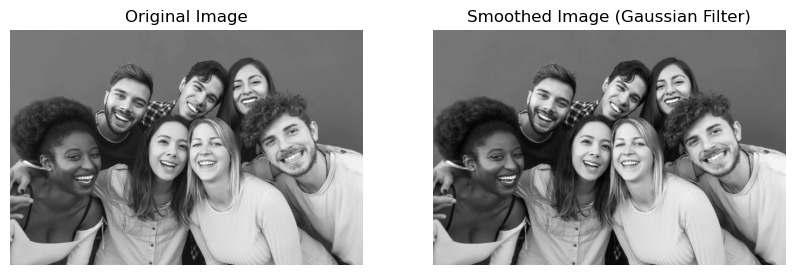

In [134]:
# step 1: Apply Gaussian smoothing on the image.
gaussian_kernel = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
gaussian_blur = filtering_2d(img_matrix, gaussian_kernel)

plt.figure(figsize=(10, 5))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_matrix, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blur, cmap='gray')
plt.title('Smoothed Image (Gaussian Filter)')
plt.axis('off')
plt.savefig(f"{result_dir}/gaussian-blur.jpeg")
plt.show()

gradient_x [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [28. 29. 22. ...  0.  0.  0.]
 [28. 27. 11. ...  0.  0.  0.]
 [28. 25.  3. ...  0.  0.  0.]]
gradient_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [0. 1. 8. ... 0. 0. 0.]
 [0. 1. 7. ... 0. 0. 0.]
 [0. 1. 5. ... 0. 0. 0.]]


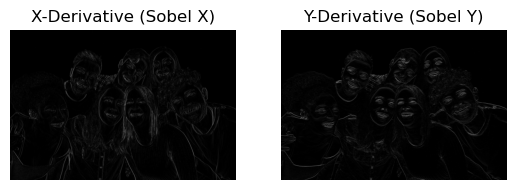

In [135]:
# step 2: Get X, and Y Derivatives using Sobel operator

kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

gradient_x = filtering_2d(img_matrix, kernel_x, True)
gradient_y = filtering_2d(img_matrix, kernel_y, True)

print("gradient_x", gradient_x)
print("gradient_y", gradient_y)

# X-derivative
plt.subplot(1, 2, 1)
plt.imshow(gradient_x, cmap="gray")
plt.title("X-Derivative (Sobel X)")
plt.axis("off")

# Y-derivative
plt.subplot(1, 2, 2)
plt.imshow(gradient_y, cmap="gray")
plt.title("Y-Derivative (Sobel Y)")
plt.axis("off")

plt.savefig(f"{result_dir}/x-and-y-derivatives.jpeg")
plt.show()

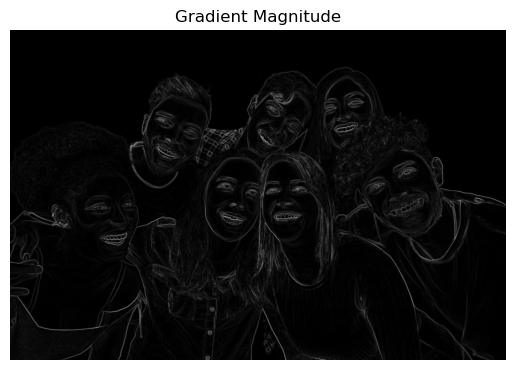

In [136]:
# step 3: compute gradient magnitude

gradient_magnitude = get_grad_mag(gradient_x, gradient_y)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.savefig(f"{result_dir}/gradient-magnitude.jpeg")
plt.show()


In [137]:
# step 4: compute gradient angle
gradient_angle = get_grad_mag(gradient_x, gradient_y)

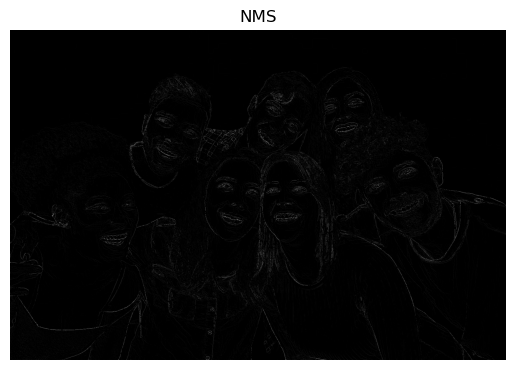

In [138]:
# step 5: Calculate NMS value

angle_classification_array = angle_classification(gradient_angle)
nms_image = non_max_suppression(gradient_magnitude, angle_classification_array)
nms_image_display = (nms_image / np.max(nms_image) * 255).astype(np.uint8)

plt.imshow(nms_image_display, cmap="gray")
plt.title("NMS")
plt.axis("off")
plt.savefig(f"{result_dir}/nms.jpeg")
plt.show()

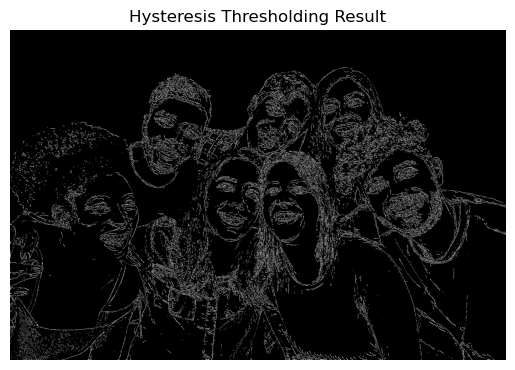

In [139]:
# Define low and high thresholds
low_threshold = 50
high_threshold = 100

# Apply hysteresis thresholding
hysteresis_image = hysteresis_thresholding(nms_image, low_threshold, high_threshold)

# Display the result
plt.imshow(hysteresis_image, cmap='gray')
plt.title('Hysteresis Thresholding')
plt.axis('off')

plt.savefig(f"{result_dir}/hysterisis-thresholding.jpeg")
plt.show()